In [23]:
# PyTorch本体
import torch
import torch.nn.functional as F

# PyG（PyTorch Geometric）関連
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

# 可視化まわり
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [24]:
# PyTorchのサンプルデータでGNNを試す
dataset = KarateClub()
data = dataset[0]  # このデータセットはグラフが1個だけ入ってる

In [25]:
def check_graph(data):
    print("Num of nodes:", data.num_nodes)
    print("Num of edges:", data.num_edges)
    print("Num of node features:", data.num_node_features)
    print("Node features shape:", data.x.shape)
    print("Edge index shape:", data.edge_index.shape)
    print("Labels (y) shape:", data.y.shape)
    print("Has isolated nodes?:", data.contains_isolated_nodes())
    print("Has self loops?:", data.contains_self_loops())
    print("Data keys:", data.keys)


In [26]:
check_graph(data)

Num of nodes: 34
Num of edges: 156
Num of node features: 34
Node features shape: torch.Size([34, 34])
Edge index shape: torch.Size([2, 156])
Labels (y) shape: torch.Size([34])
Has isolated nodes?: False
Has self loops?: False
Data keys: <bound method BaseData.keys of Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])>


/Users/sei/Desktop/ice-cube-nutrino/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/Users/sei/Desktop/ice-cube-nutrino/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [27]:
print(data.y)


tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


In [28]:
def show_graph(data, title="Graph", label=True):
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np
    from torch_geometric.utils import to_networkx

    # PyGのデータをNetworkXに変換
    nxg = to_networkx(data)

    # 各ノードのPageRank（可視化用のノードサイズに使う）
    pr = nx.pagerank(nxg)
    pr_max = np.array(list(pr.values())).max()

    # レイアウト計算（spring layout：自然なレイアウト）
    draw_pos = nx.spring_layout(nxg, seed=0)

    # ラベルごとの色設定
    plt.figure(figsize=(10, 10))
    if label:
        cmap = plt.get_cmap('tab10')
        labels = data.y.numpy()
        colors = [cmap(l) for l in labels]
        nx.draw_networkx_nodes(nxg, draw_pos,
                               node_size=[v / pr_max * 1000 for v in pr.values()],
                               node_color=colors,
                               alpha=0.5)
    else:
        nx.draw_networkx_nodes(nxg, draw_pos,
                               node_size=[v / pr_max * 1000 for v in pr.values()],
                               alpha=0.5)

    # エッジ & ラベル表示
    nx.draw_networkx_edges(nxg, draw_pos, alpha=0.2)
    nx.draw_networkx_labels(nxg, draw_pos, font_size=10)

    plt.title(title)
    plt.show()


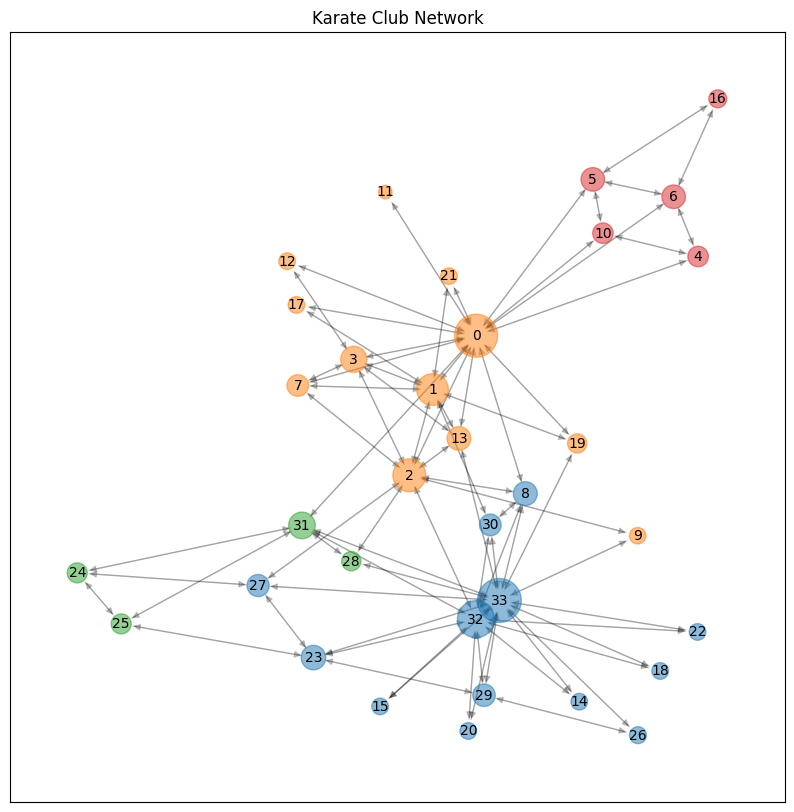

In [29]:
show_graph(data, "Karate Club Network", label=True)


In [30]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCNベースのノード分類モデル
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_size = 5  # 中間層の次元数

        self.conv1 = GCNConv(in_channels=34, out_channels=hidden_size)
        self.conv2 = GCNConv(in_channels=hidden_size, out_channels=4)  # 4 = クラス数

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  # ノード特徴とグラフ構造
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # 出力：ノードごとのクラスの確率（log）

In [31]:
model = Net()
print(model)

Net(
  (conv1): GCNConv(34, 5)
  (conv2): GCNConv(5, 4)
)


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)
data = data.to(device)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [34]:
model.train()

for epoch in range(100):
    optimizer.zero_grad()           # 勾配の初期化
    out = model(data)               # 順伝播
    loss = F.nll_loss(out, data.y)  # 負の対数尤度損失（log_softmax対応）
    loss.backward()                 # 逆伝播
    optimizer.step()                # パラメータ更新

    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")

Epoch 000 | Loss: 1.3920
Epoch 020 | Loss: 1.1226
Epoch 040 | Loss: 0.8484
Epoch 060 | Loss: 0.5588
Epoch 080 | Loss: 0.3433


In [35]:
model.eval()

Net(
  (conv1): GCNConv(34, 5)
  (conv2): GCNConv(5, 4)
)

In [36]:
out = model(data)          # 予測の log-softmax 出力（形: [34, 4]）
_, pred = out.max(dim=1)   # 各ノードについて「一番確率が高いクラス」を選ぶ


In [37]:
correct = (pred == data.y).sum().item()     # 正解した数
acc = correct / data.num_nodes              # 正解率（Accuracy）

print("予測結果：", pred)
print("正解ラベル：", data.y)
print(f"Accuracy: {acc:.4f}")


予測結果： tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 0, 0, 0, 2, 0, 0])
正解ラベル： tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
Accuracy: 0.9706


In [38]:
# 今回のice-cubeのデータでも実装
import polars as pl
dfTrainMeta = pl.read_parquet("../train_meta.parquet")
dfTrainMeta = dfTrainMeta.filter(pl.col("batch_id") == 1)


In [39]:
dfSensorGeo = pl.read_csv("../sensor_geometry.csv")

In [40]:
# センサーの位置を正規化
dfSensorGeo = dfSensorGeo.with_columns((pl.col("x") / pl.col("x").max()).alias("x"))
dfSensorGeo = dfSensorGeo.with_columns((pl.col("y") / pl.col("y").max()).alias("y"))
dfSensorGeo = dfSensorGeo.with_columns(((pl.col("z") - pl.col("z").min()) / (pl.col("z").max() - pl.col("z").min())).alias("z"))

In [41]:
dfSensorGeo = dfSensorGeo.with_columns([
    pl.col("x").clip(-1.0, 1.0).alias("x"),
    pl.col("y").clip(-1.0, 1.0).alias("y"),
    pl.col("z").clip(-1.0, 1.0).alias("z")
])



In [42]:
# 全てのデータを集約
dfTrainBatch = pl.read_parquet("../batch_1.parquet")
dfTrainBatch = dfTrainBatch.with_columns(pl.col("sensor_id").cast(pl.Int64))


In [43]:
dfTrain = dfTrainMeta.join(dfTrainBatch, on="event_id", how="inner")


In [44]:
dfTrain = dfTrain.join(dfSensorGeo, on="sensor_id", how="inner")


In [45]:
nextSensor = pl.col("sensor_id").shift(-1).over("event_id").alias("next_sensor") # 時系列順に次に反応したセンサー
dfTrain = dfTrain.with_columns(nextSensor)


In [46]:
dfTrain

batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith,sensor_id,time,charge,auxiliary,x,y,z,next_sensor
i64,i64,i64,i64,f64,f64,i64,i64,f64,bool,f64,f64,f64,i64
1,24,0,60,5.029555,2.087498,3918,5928,1.325,true,0.526415,0.658763,0.693478,4157
1,24,0,60,5.029555,2.087498,4157,6115,1.175,true,-0.252355,0.734524,0.699406,3520
1,24,0,60,5.029555,2.087498,3520,6492,0.925,true,0.876642,0.506143,0.326033,5041
1,24,0,60,5.029555,2.087498,5041,6665,0.225,true,-0.016795,-0.156035,0.66882,2948
1,24,0,60,5.029555,2.087498,2948,8054,1.575,true,1.0,0.335466,0.839326,860
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,3266196,32792280,32792415,3.017863,1.213878,1961,17617,0.975,true,-0.562816,-0.183376,0.303746,36
1,3266196,32792280,32792415,3.017863,1.213878,36,17705,0.625,true,-0.444402,-1.0,0.381827,356
1,3266196,32792280,32792415,3.017863,1.213878,356,18192,0.725,true,0.626334,-0.829892,0.057038,2826


In [47]:
# ３つのイベントに関して、グラフ構造を可視化
listEvent = list(set(dfTrain.get_column("event_id").to_list()))

dfSample1 = dfTrain.filter(pl.col("event_id")==listEvent[0])
dfSample2 = dfTrain.filter(pl.col("event_id")==listEvent[1])
dfSample3 = dfTrain.filter(pl.col("event_id")==listEvent[2])


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


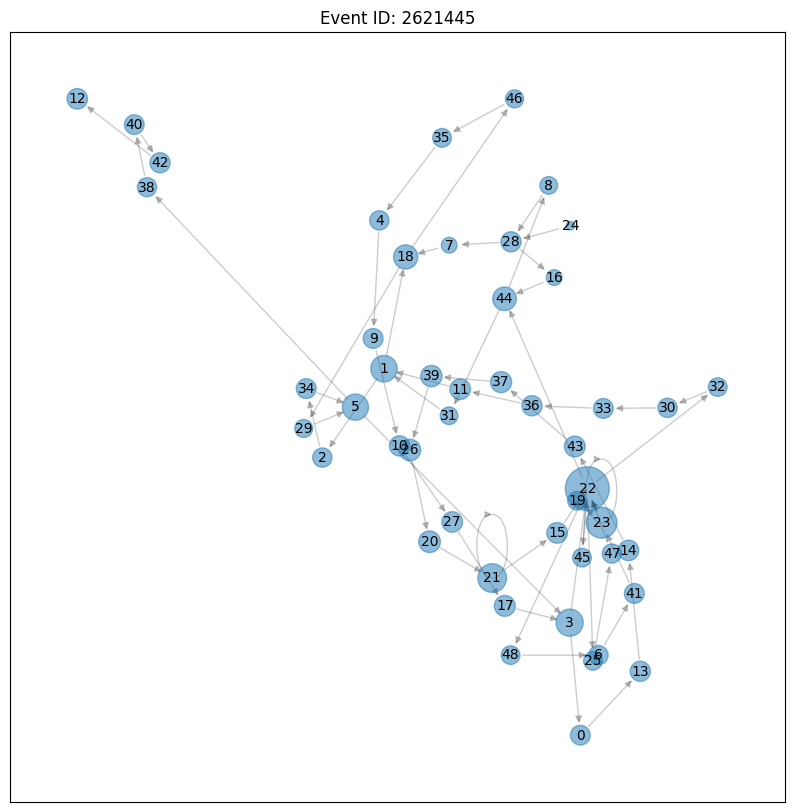

Num of nodes: 49
Num of edges: 62
Num of node features: 3
Node features shape: torch.Size([49, 3])
Edge index shape: torch.Size([2, 62])
Labels (y) shape: torch.Size([2])
Has isolated nodes?: False
Has self loops?: True
Data keys: <bound method BaseData.keys of Data(x=[49, 3], edge_index=[2, 62], y=[2])>
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


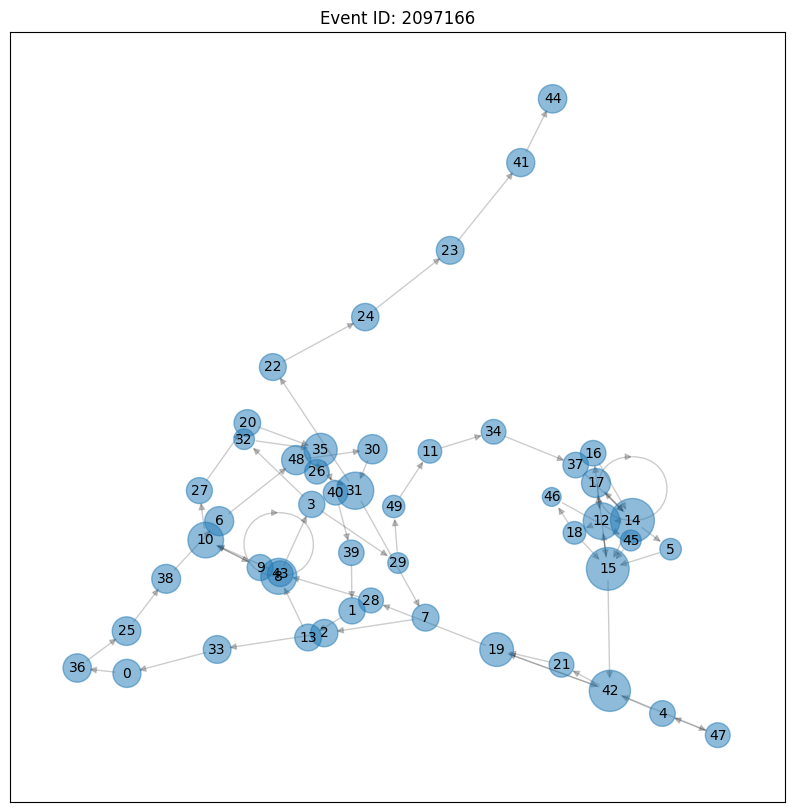

Num of nodes: 50
Num of edges: 73
Num of node features: 3
Node features shape: torch.Size([50, 3])
Edge index shape: torch.Size([2, 73])
Labels (y) shape: torch.Size([2])
Has isolated nodes?: False
Has self loops?: True
Data keys: <bound method BaseData.keys of Data(x=[50, 3], edge_index=[2, 73], y=[2])>
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


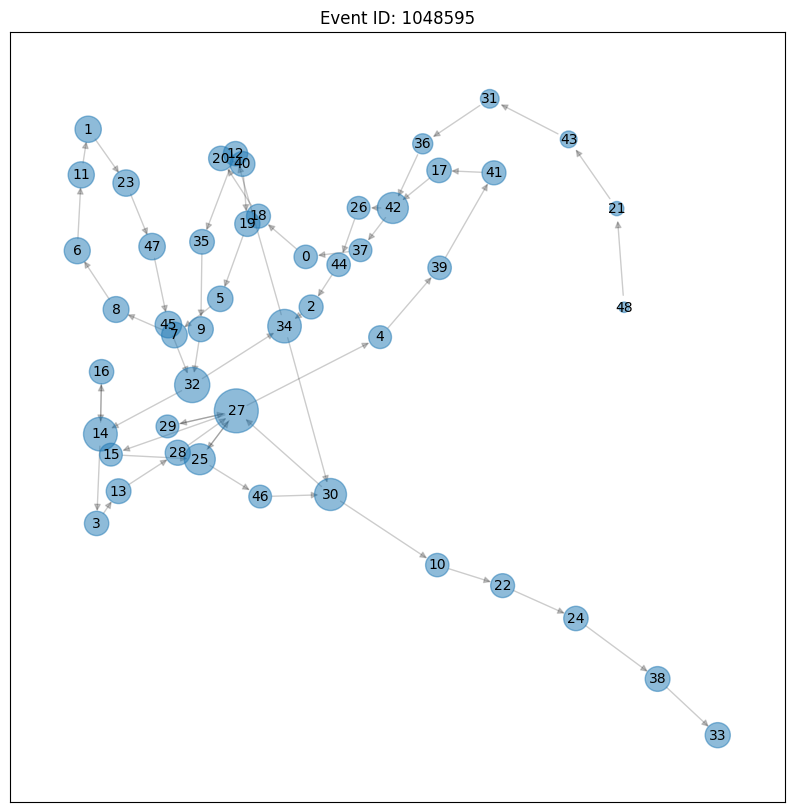

Num of nodes: 49
Num of edges: 57
Num of node features: 3
Node features shape: torch.Size([49, 3])
Edge index shape: torch.Size([2, 57])
Labels (y) shape: torch.Size([2])
Has isolated nodes?: False
Has self loops?: False
Data keys: <bound method BaseData.keys of Data(x=[49, 3], edge_index=[2, 57], y=[2])>


In [48]:
n=0
for df in [dfSample1, dfSample2, dfSample3]:
    l = list(set(df.get_column("sensor_id").to_list()))
    dictSensors = {}
    for k, v in enumerate(l):
        dictSensors[v] = k

    df_map = pl.DataFrame({
        "sensor_id": list(dictSensors.keys()),
        "newSensorID": list(dictSensors.values())
    })

    df = df.join(df_map, on="sensor_id", how="left")

    nextSensor = pl.col("newSensorID").shift(-1).over("event_id").alias("next_newSensorID")
    df = df.with_columns(nextSensor)
    
    edgeID = [df.get_column("newSensorID").to_list()[:-1], df.get_column("next_newSensorID").to_list()[:-1]]
    edge_index = torch.tensor(edgeID, dtype=torch.long)

    dfNodeF = df.select(["x", "y", "z", "newSensorID"]).sort("newSensorID").unique().select(["x", "y", "z"])
    nodeID = [dfNodeF.get_column("x").to_list(), dfNodeF.get_column("y").to_list(), dfNodeF.get_column("z").to_list()]
    nodeID = np.array(nodeID).T
    x = torch.tensor(nodeID, dtype=torch.float)
    
    y_vals = [df.get_column("azimuth")[0], df.get_column("zenith")[0]]
    y = torch.tensor(y_vals, dtype=torch.float)
    
    data = Data(x=x, edge_index=edge_index, y=y)

    print("+"*100)
    show_graph(data, f'Event ID: {listEvent[n]}', label=False)
    check_graph(data)
    n += 1


In [49]:
print(len(listEvent))

200000


In [50]:
print(listEvent[:10])

[2621445, 2097166, 1048595, 524309, 3145750, 1572887, 24, 3145752, 524315, 2097181]


In [51]:
from torch_geometric.data import Batch

In [52]:
listSenID = dfSensorGeo.get_column("sensor_id").to_list()
nodeID = dfSensorGeo.select(["x", "y" ,"z"]).to_numpy()

batch_input = []
for eventID in listEvent[:1000]:
    
    df = dfTrain.filter(pl.col("event_id")==eventID)
    
    # Prepare edge_index: sensor ID -> next sensor ID.
    edgeID = [df.get_column("sensor_id").to_list()[:-1], df.get_column("next_sensor").to_list()[:-1]]
    edge_index = torch.tensor(edgeID, dtype=torch.long)
    
    # Create list of sensor ID in scope
    l = list(set(df.get_column("sensor_id").to_list()))
    
    # Prepare x: the position of sensor in [[x0,y0,z0], [x1,y1,z1],...]

    x = torch.tensor(nodeID, dtype=torch.float)
    l = set(df.get_column("sensor_id").to_list())
    mask = [i for i, sid in enumerate(listSenID) if sid not in l]
    x[mask] = 0
    
    # Prepare y: [azimuth, zenith]
    y = torch.tensor([df.get_column("azimuth").to_list()[0], df.get_column("zenith").to_list()[0]])
    
    # Prepare data
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Append data to the list of batch
    batch_input.append(data)
    
batch = Batch.from_data_list(batch_input)

In [53]:
batch.to_data_list()

[Data(x=[5160, 3], edge_index=[2, 62], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 73], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 57], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 39], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 71], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 64], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 60], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 58], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 86], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 260], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 34], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 65], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 50], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 50], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 46], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 47], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 37], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 79], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 50], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 59], y=[2]),
 Data(x=[5160, 3], edge_index=[2, 32], y=[2]),
 Data(x=[516

In [54]:
# create DataLoader obj. from batch obj. in case of edge_index have different shape
loader = DataLoader(batch, batch_size=1, shuffle=True)

/Users/sei/Desktop/ice-cube-nutrino/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [55]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        x = x.mean(dim=0, keepdim=True)  # take the mean along the first dimension
        x = x.reshape(1, -1)  # reshape to [1, 2]
        return x

# Define the model, optimizer and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [56]:
# Train the model
model.train()
for epoch in range(100):
    running_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index)
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if (epoch+1) % 20 == 0:
        print("Epoch {}: loss={}".format(epoch+1, running_loss))

/Users/sei/Desktop/ice-cube-nutrino/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 